# Parcel

This is a footnote [^mynote]
{cite:ps}`python2023`

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from core import (
    normality_test,
    plot_sequence,
    add_date_to_data,
    plot_sequence_with_date,
    holt_winters_multiplicative,
    compute_descriptive_statistics,
    zero_mean_test,
    constant_variance_test,
)

In [2]:
data_path = Path.cwd().parent.parent / "data/Parcel sin tiempo.sav"

Read the data

In [3]:
raw_data = pd.read_spss(data_path)

Plot the data sequentially

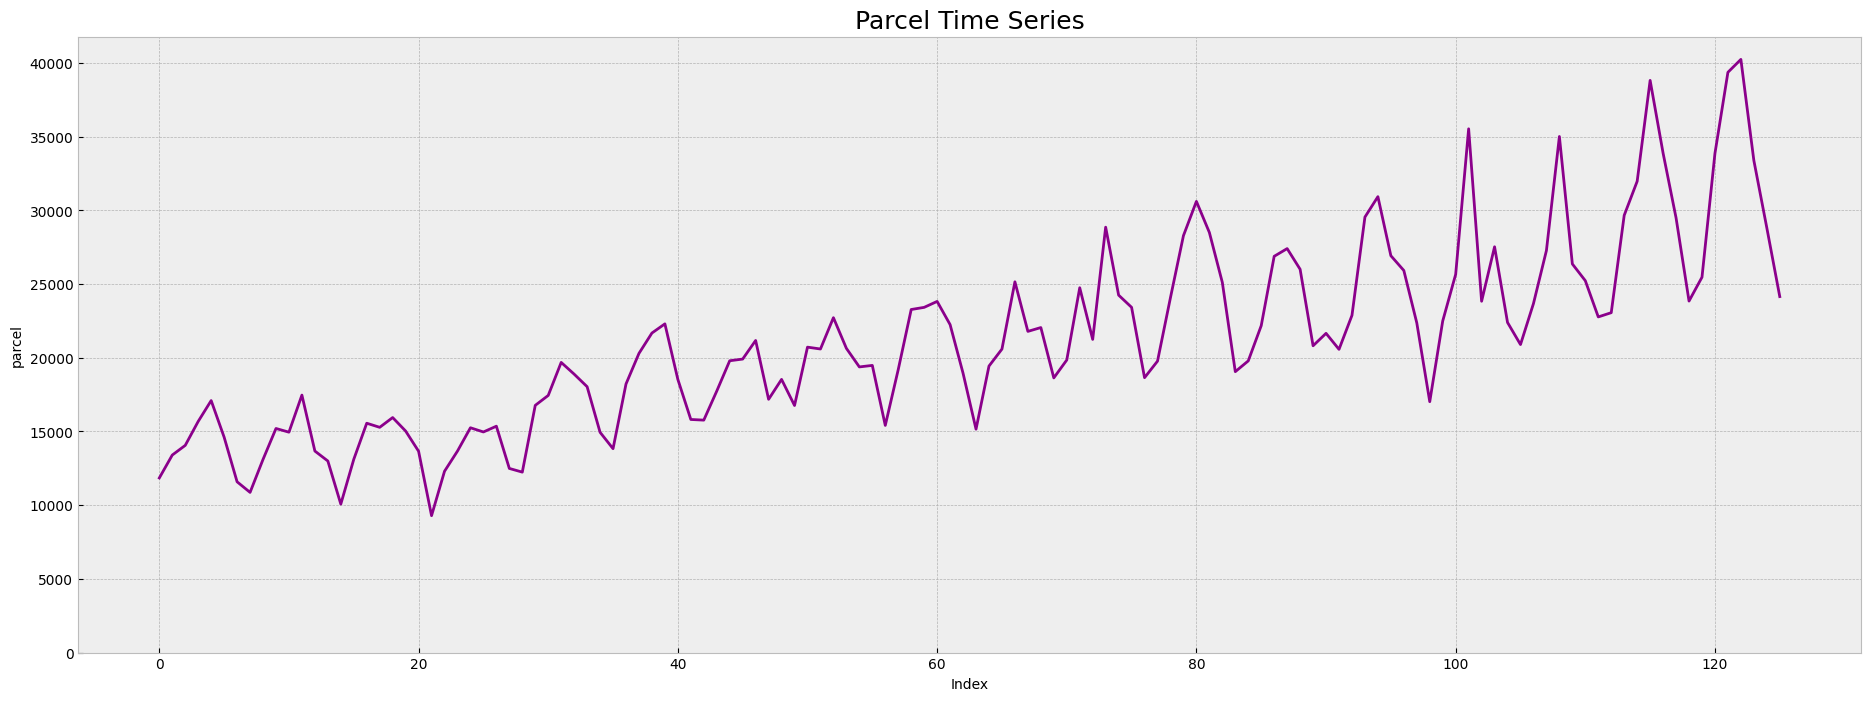

In [4]:
plot_sequence(raw_data.parcel, 'Parcel Time Series');

Adding datetime variables to dataset assuming one observation per day

In [5]:
data_with_dates = add_date_to_data(raw_data)
data_with_dates.head()

,parcel,date,day,week
0,11844.29,1970-01-04,1,1
1,13398.57,1970-01-05,2,2
2,14054.29,1970-01-06,3,2
3,15680.00,1970-01-07,4,2
4,17092.86,1970-01-08,5,2


Plot the data with temporal columns

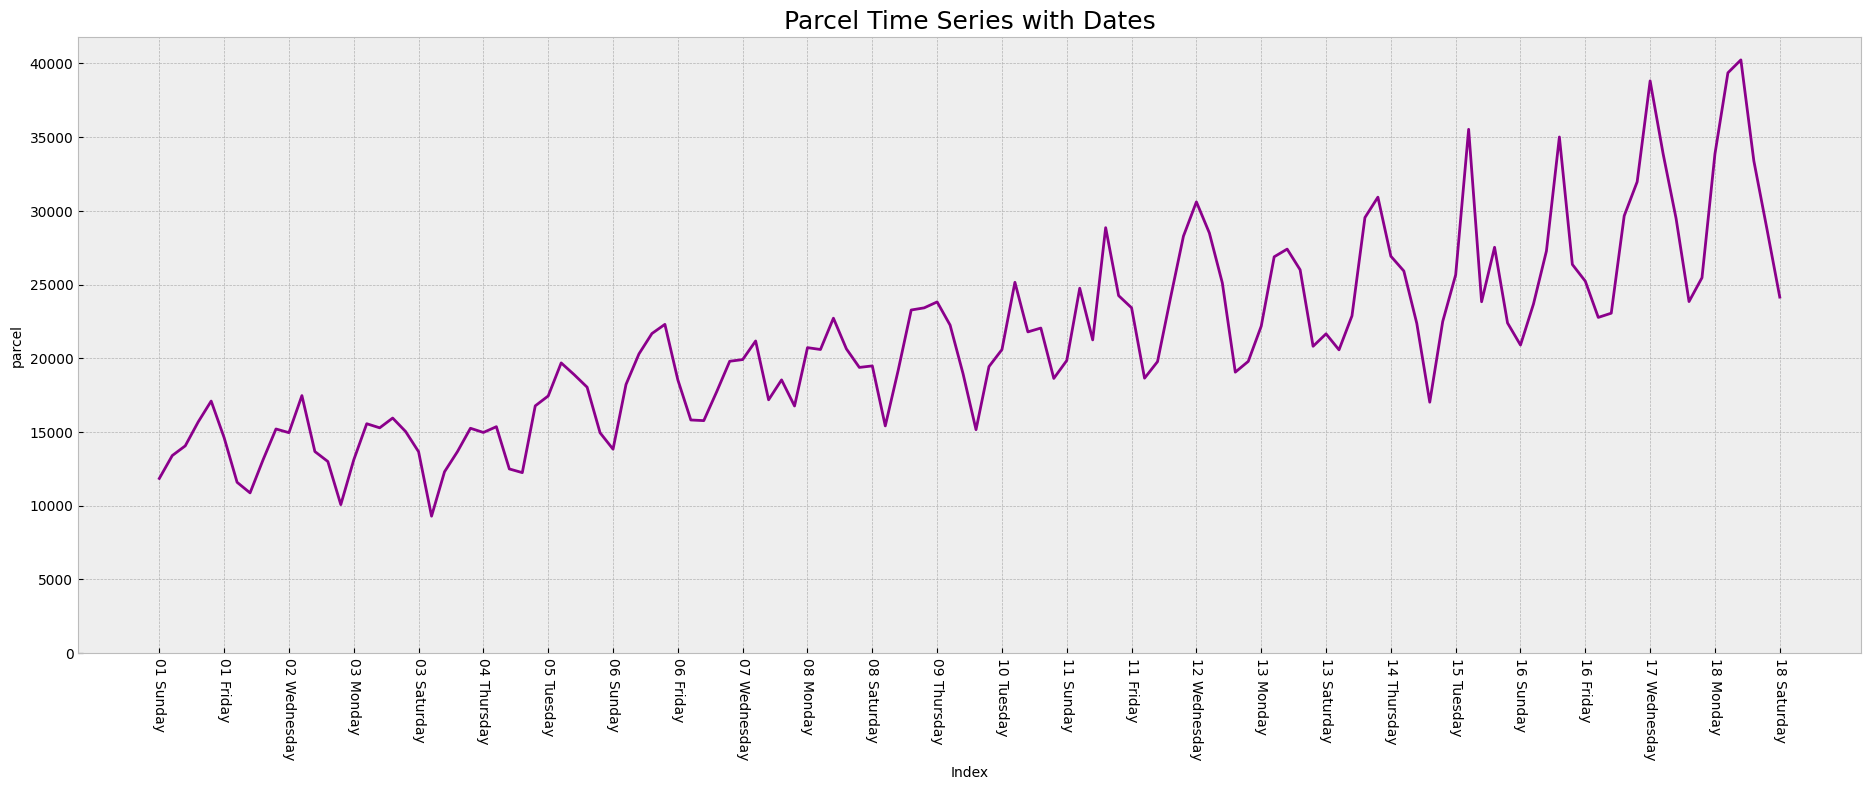

In [6]:
plot_sequence_with_date(data_with_dates, "parcel", "date", 'Parcel Time Series with Dates');

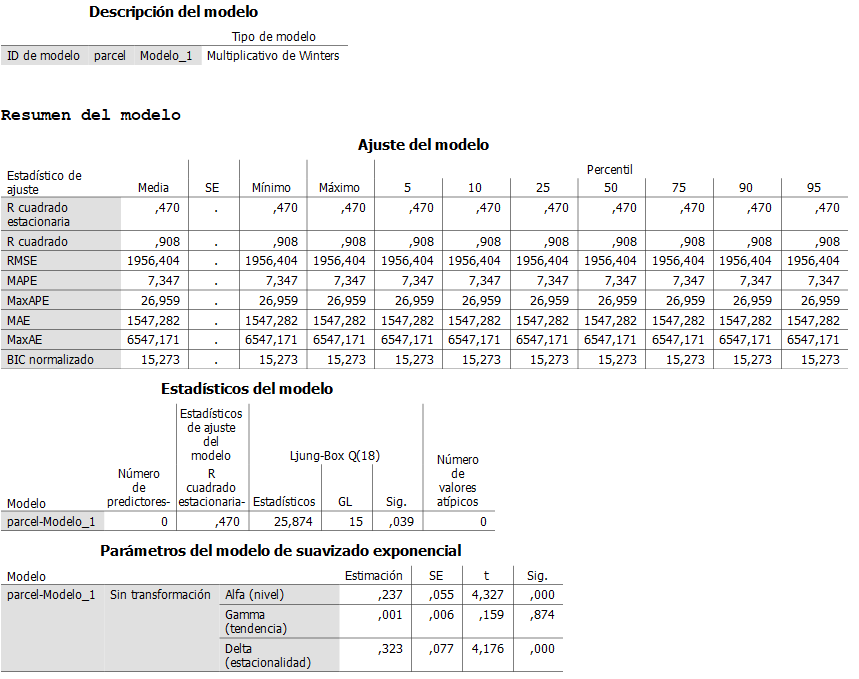

In [7]:
fit_model = holt_winters_multiplicative(data_with_dates, "parcel", "date", 7)
print(f"RMSE: {fit_model.rmse:.3f}")
print(f"R^2: {fit_model.r_squared:.3g}")

for parameter in fit_model.parameters:
    print(parameter)

RMSE: 1931.901
R^2: 0.909
smoothing_level: 0.2255 ± 0.0548 (0.1169, 0.3340) - t-statistic: 4.1106 - p-value: 0.0001
smoothing_trend: 0.0000 ± 0.2391 (-0.4733, 0.4733) - t-statistic: 0.0000 - p-value: 1.0000
smoothing_seasonal: 0.2432 ± 0.0781 (0.0887, 0.3977) - t-statistic: 3.1149 - p-value: 0.0023


It was identified that the trend parameter CI includes zero and thus is not statistically significant. Therefore a different model should be used without a trend component.

In [8]:
predictions = fit_model.predict(0, len(data_with_dates)-1)
data_with_forecast_and_residuals = data_with_dates.assign(
                                        forecast=predictions.values,
                                        residuals=fit_model.residuals,
                                    )
data_with_forecast_and_residuals.head()

,parcel,date,day,week,forecast,residuals
0,11844.29,1970-01-04,1,1,11056.290805,787.999195
1,13398.57,1970-01-05,2,2,13698.813609,-300.243609
2,14054.29,1970-01-06,3,2,14991.895739,-937.605739
3,15680.00,1970-01-07,4,2,15645.351024,34.648976
4,17092.86,1970-01-08,5,2,16189.059533,903.800467


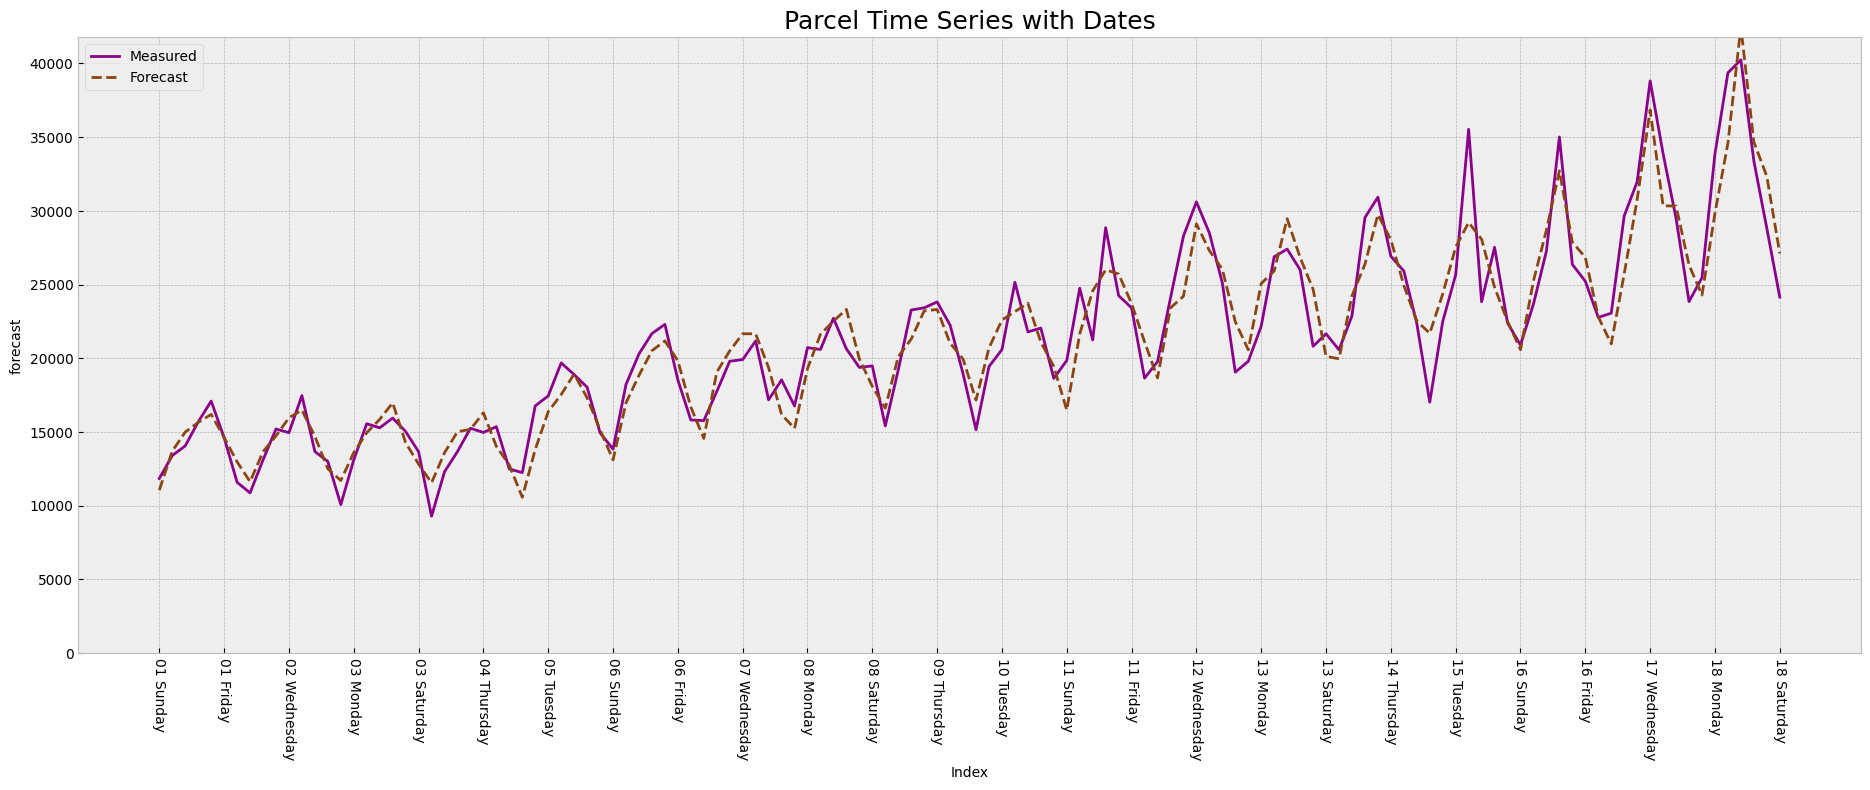

In [9]:
ax = plt.subplot()
plot_sequence_with_date(
    data_with_forecast_and_residuals,
    "parcel",
    "date",
    'Parcel Time Series with Dates',
    ax=ax,
    label="Measured"
)
plot_sequence_with_date(
    data_with_forecast_and_residuals,
    "forecast",
    "date",
    'Parcel Time Series with Dates',
    ax=ax,
    ls="--",
    label="Forecast"
)
plt.legend();

## Model Assumptions

1. The residuals should be normally distributed.
1. The residuals should have constant variance (homoscedasticity).
1. The residuals should be independent.
1. The residuals should have zero mean.
1. The residuals should be random

In [10]:
significance = 0.05
residuals = data_with_forecast_and_residuals["residuals"]
descriptive_stats = compute_descriptive_statistics(residuals)
descriptive_stats

DescriptiveStatistics(mean=-5.236409432676188, variance=3732213.6870611175, standard_deviation=1931.8938084328336, standard_error=172.1067794948941, degrees_of_freedom=125)

## Test for normality

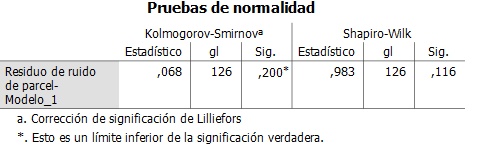

In [11]:
normality_test(residuals, significance_level=significance)

Kolmogorov-Smirnov statistic with Lilliefors correction: 0.0647
p-value: 0.2672
Fail to reject null hypothesis: The data may be normally distributed.


## Test for means Zero

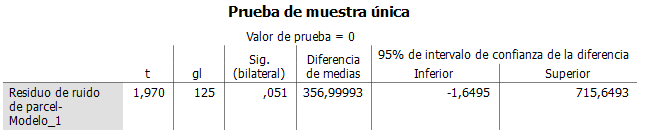

In [12]:
zero_mean_test(residuals, descriptive_stats, significance_level=significance)

Data mean: -5.2364
p-value: 0.9758
95% CI for Residual Mean: [-345.8571, 335.3843]
Fail to reject null hypothesis: The residuals may have zero mean.


## Test for constant variance

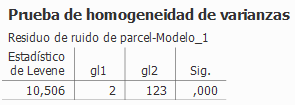

In [13]:
constant_variance_test(residuals, significance_level=significance)

Variances: ['1_279_895', '3_402_299', '6_416_387']
Levene's test statistic: 10.6112
p-value: 0.0001
Reject null hypothesis: Variances are not equal. - Heteroscedasticity detected.


## Test for Independence

array([[ 1.        ,  1.        ],
       [-0.1543303 ,  0.19488464],
       [-0.06487158,  0.28448691],
       [-0.31314441,  0.04039803],
       [-0.21176714,  0.14813322],
       [-0.29842829,  0.06181493]])

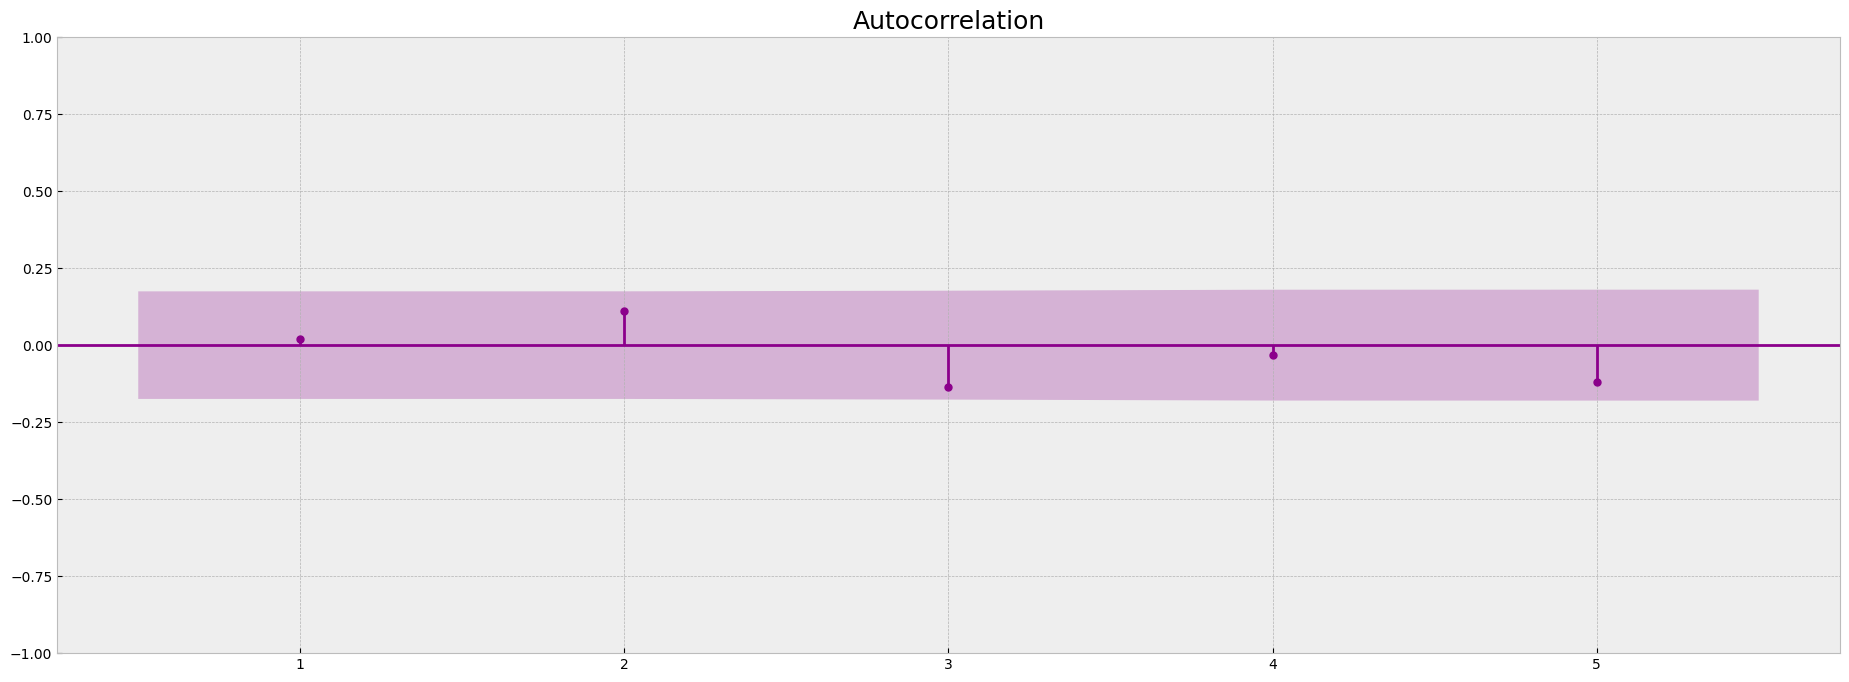

In [14]:
from statsmodels.graphics import tsaplots
from statsmodels.tsa import stattools

tsaplots.plot_acf(residuals, lags=list(range(1, 6)))
acf_values, confint, qstat, p_values = stattools.acf(residuals, nlags=5, fft=False, qstat=True, alpha=0.05)
confint

```{bibliography}
:style: plain
```